In [ ]:
! pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.4 MB/s eta 0:00:00


In [ ]:
import os
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision
from torcheval.metrics.functional import multiclass_accuracy, multiclass_auprc
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# library paths
import sys
path_load = '/content/drive/MyDrive/Deep_learning_course/Lung_segmentation/classification_problem/'
sys.path.append(path_load)

In [ ]:
from custom_load_resnet import LungDatasetClassif
from data_loading_resnet import load_train_data, load_test_data, load_train_eval_data
from resnet18_dual_model import ResNet18_dual

### Move data to localpath

In [ ]:
path_to_zip_folder = '/content/drive/MyDrive/Deep_learning_course/Lung_segmentation/data/m3ex02-data.zip'
current_folder_path = '/content/localpath/'
!unzip -q $path_to_zip_folder -d $current_folder_path

### Define parameters

In [ ]:
# data parameters
path_test: str = '/content/localpath/m3ex02-data/Test/'
path_train: str = '/content/localpath/m3ex02-data/Train/'
# training parameters
batch_size: int = 900
workers: int = 8
device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model parameters
path_load: str = '/content/drive/MyDrive/Deep_learning_course/Lung_segmentation/classification_problem/models/'
name_load: str = 'covid_classif_masks_11.pkl'
in_channels: int = 1
num_classes: int = 3
metrics: list = [multiclass_accuracy, multiclass_auprc]

### Load data

In [ ]:
data_test = load_test_data(
    path_test,
    batch_size=batch_size,
    resize=(224, 224),
    workers=workers,
    pin_memory_device=device
)

In [ ]:
data_train = load_train_data(
    path_train,
    batch_size=batch_size,
    # resize=(224, 224),
    workers=workers,
    pin_memory_device=device
)

### Load pre-trained models

In [ ]:
model = ResNet18_dual(img_channels=in_channels, num_classes=num_classes)
state = torch.load(os.path.join(path_load, name_load))
model.load_state_dict(state["model"])
model = model.to(device)
#  map_location=torch.device('cpu')

In [ ]:
def test_model(model_, data_test, classes):
  tot = len(data_test)
  model_.to(device)
  model_.eval()
  with torch.no_grad():
    test_metrics_by_class = []
    test_metrics = []
    y_true_cm, y_pred_cm = [], []

    for i, (batch) in tqdm(enumerate(data_test), total=tot):
      batch_x = batch["image"].to(device)
      batch_mask = batch["mask"].to(device)
      batch_y = batch["class"].to(device)

      y_pred = model_(batch_x, batch_mask)
      y_pred_max = torch.argmax(y_pred, axis=1)
      acc = multiclass_accuracy(y_pred, batch_y, average=None, num_classes=classes)
      rcl = multiclass_accuracy(y_pred, batch_y)

      test_metrics_by_class.append(acc.detach().cpu().numpy())
      test_metrics.append(rcl.detach().cpu().numpy())
      y_true_cm.extend(batch_y.tolist())
      y_pred_cm.extend(y_pred_max.tolist())

    test_metrics = np.mean(test_metrics, axis=0)
    test_metrics_by_class = np.nanmean(test_metrics_by_class, axis=0)

  return test_metrics, test_metrics_by_class, confusion_matrix(y_true_cm, y_pred_cm)

In [ ]:
def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

In [ ]:
output = test_model(model, data_test, num_classes)

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
output[0]

0.5289185

In [ ]:
output[1]

array([0.40482414, 0.82273144, 0.3341647 ], dtype=float32)

In [ ]:
output[2]

array([[ 970, 1161,  264],
       [ 301, 1842,  110],
       [ 343, 1152,  645]])

In [ ]:
output_train = test_model(model, data_train, num_classes)

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
output_train[0]

0.47848693

In [ ]:
output_train[1]

array([0.5367038 , 0.69705397, 0.16039532], dtype=float32)

In [ ]:
output_train[2]

array([[4107, 3272,  279],
       [1935, 5057,  216],
       [2528, 3231, 1090]])

In [ ]:
data_test.dataset.class_to_idx

{'COVID-19': 0, 'Non-COVID': 1, 'Normal': 2}

In [ ]:
a = [data_test.dataset[i]['class'] for i in range(len(data_test.dataset))]

In [ ]:
b = [data_train.dataset[i]['class'] for i in range(len(data_train.dataset))]

In [ ]:
from collections import Counter
Counter(b)

Counter({0: 7658, 2: 6849, 1: 7208})

In [ ]:
[i for i in range(len(data_test.dataset)) if data_test.dataset[i]['class'] == 1]

In [ ]:
i = 5481

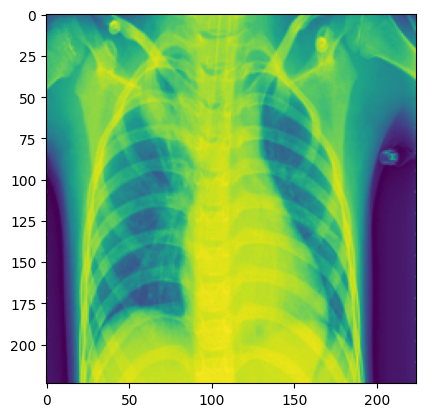

In [ ]:
plt.imshow(data_test.dataset[i]["image"][0])

In [ ]:
X = data_test.dataset[i]
image = X["image"].unsqueeze(0).to(device)
mask = X["mask"].unsqueeze(0).to(device)

In [ ]:
mask.shape

torch.Size([1, 1, 224, 224])

In [ ]:
model.eval()
model.to(device)

In [ ]:
model(image, mask)

tensor([[-3.4671, -4.5207,  9.7999]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
plot_confusion_matrix(
    output_train[2],
    data_test.dataset.classes,
    "AlexNet disease identification: Normalized Confusion Matrix"
  )